  3
 32
 32
[torch.LongStorage of size 3]



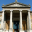

  1
  3
 32
 32
[torch.LongStorage of size 4]



In [86]:
img = image.load('oxbuild/training/ashmolean_000007|2.jpg',3,'byte')
img = image.scale(img,'^32')
img = image.crop(img,'c',32,32)
print(#img)
itorch.image(img)
tensor = torch.Tensor(torch.LongStorage({1,3,32,32}))
tensor[1] = img
print(#tensor)

In [87]:
name = 'ashmolean_000007|2.jpg'
label = tonumber(string.split(name,'|')[2]:sub(1,1))
print(label)

prefix = name:sub(1,2)
if (prefix == 'al') then
    label = 1
end
if (prefix == 'as') then
    label = 2
end
if (prefix == 'ch') then
    label = 3
end
if (prefix == 'he') then
    label = 4
end
if (prefix == 'ra') then
    label = 5
end
print(label)

2	
2	


In [88]:
require 'image'
require 'paths'
N = 0
for f in paths.files('oxbuild/training/') do
    if f:sub(1,1)~='.' then
        N=N+1
    end
end

data = torch.Tensor(torch.LongStorage({N,3,32,32}))
label = torch.Tensor(torch.LongStorage({N}))

i = 1
for name in paths.files('oxbuild/training/') do
    if name:sub(1,1)~='.' then
        img = image.load('oxbuild/training/'..name,3,'byte')
        img = image.scale(img,'^32')
        img = image.crop(img,'c',32,32)
        data[i] = img
        label[i] = tonumber(string.split(name,'|')[2]:sub(1,1))
        i = i+1
    end
end


print(#data)
print(#label)
-- print(label)

trainset = {}
trainset.data = data
trainset.label = label
print(trainset)

 102
   3
  32
  32
[torch.LongStorage of size 4]

 102
[torch.LongStorage of size 1]

{
  data : DoubleTensor - size: 102x3x32x32
  label : DoubleTensor - size: 102
}


In [89]:
N = 0
for f in paths.files('oxbuild/classification/') do
    if f:sub(1,1)~='.' then
        N=N+1
    end
end

data = torch.Tensor(torch.LongStorage({N,3,32,32}))
label = torch.Tensor(torch.LongStorage({N}))

i = 1
for f in paths.files('oxbuild/classification/') do
    if f:sub(1,1)~='.' then
        img = image.load('oxbuild/classification/'..f,3,'byte')
        img = image.scale(img,'^32')
        img = image.crop(img,'c',32,32)
        data[i] = img
        class = f:sub(1,2)
        if (class == 'al') then
            label[i] = 1
        end
        if (class == 'as') then
            label[i] = 2
        end
        if (class == 'ch') then
            label[i] = 3
        end
        if (class == 'he') then
            label[i] = 4
        end
        if (class == 'ra') then
            label[i] = 5
        end
        i = i+1
    end
end


-- print(#data)
-- print(#label)
-- -- print(label)

testset = {}
testset.data = data
testset.label = label
print(testset)

{
  data : DoubleTensor - size: 102x3x32x32
  label : DoubleTensor - size: 102
}
 102
   3
  32
  32
[torch.LongStorage of size 4]



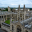

all_souls	


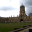

In [90]:
classes = {'all_souls', 'ashmolean', 'christ_church', 'hertford',
           'radcliffe_camera', 'distractor'}
print(trainset)
print(#trainset.data)
itorch.image(trainset.data[20]) -- display the 100-th image in dataset
print(classes[trainset.label[20]])

itorch.image(testset.data[40]) -- display the 100-th image in dataset
print(classes[testset.label[40]])

-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [91]:
mean = {0,0,0} -- store the mean, to normalize the test set in the future
stdv = {1,1,1} -- store the standard-deviation for the future
-- mean = {}
-- stdv = {}
-- for i=1,3 do -- over each image channel
--     mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
--     print('Channel ' .. i .. ', Mean: ' .. mean[i])
--     trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
--     stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
--     print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
--     trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
-- end

In [92]:
require 'nn';
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 6))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems
-- net = net:cuda() --use cuda

criterion = nn.ClassNLLCriterion() --Loss function
-- criterion = criterion:cuda() --use cuda

trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 50 -- just do 5 epochs of training.
trainer:train(trainset)

# StochasticGradient: training	


# current error = 1.7039355529101	


# current error = 1.5767913382155	


# current error = 1.530266535549	


# current error = 1.4558789483663	


# current error = 1.2829425762211	


# current error = 1.131540246996	


# current error = 0.93066124676871	


# current error = 0.64280958068876	


# current error = 0.46746220748252	


# current error = 0.73406440974318	


# current error = 0.2662719868123	

# current error = 0.32464345996484	


# current error = 0.083417970410965	


# current error = 0.45131711727278	


# current error = 0.11290741434025	


# current error = 0.071036465386967	


# current error = 0.011052587583535	


# current error = 0.0057456720794135	


# current error = 0.004122604967249	


# current error = 0.0032680536478029	


# current error = 0.0027065412638878	


# current error = 0.0023127946437189	


# current error = 0.0020213300200683	


# current error = 0.0017995216556691	


# current error = 0.0016258306749287	


# current error = 0.0014814448738853	


# current error = 0.0013646254652272	


# current error = 0.0012623693831424	


# current error = 0.0011749897361323	


# current error = 0.0010984797535182	


# current error = 0.0010302146260475	


# current error = 0.00097036615224796	


# current error = 0.00091558233684961	


# current error = 0.00086753538153636	


# current error = 0.00082440346068107	


# current error = 0.00078611613743211	


# current error = 0.00075099991875901	


# current error = 0.00071887643969844	


# current error = 0.00068956633136409	


# current error = 0.00066133860375582	


# current error = 0.0006359517521119	


# current error = 0.00061214247523707	


# current error = 0.00058991173778915	


# current error = 0.00056909572155367	


# current error = 0.00055006346176249	


# current error = 0.00053170372025894	


# current error = 0.00051484230240881	


# current error = 0.00049927365408107	


# current error = 0.00048467247561112	


radcliffe_camera	


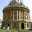

all_souls	0.0001431399164268	
ashmolean	3.1136443508317e-05	
christ_church	3.4252657289964e-06	
hertford	2.1057017378702e-05	
radcliffe_camera	3.274438444708e-05	
distractor	0.99975349707476	


In [93]:
testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end
i = 93
print(classes[testset.label[i]])
itorch.image(testset.data[i])
predicted = net:forward(testset.data[i])

predicted:exp()
for i=1,predicted:size(1) do
    print(classes[i], predicted[i])
end

In [94]:
correct = 0
for i=1,100 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print(correct, correct .. ' % ')

class_performance = {0, 0, 0, 0, 0, 0}
for i=1,100 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], class_performance[i])
end

40	40 % 	


all_souls	8	
ashmolean	14	
christ_church	6	
hertford	12	
radcliffe_camera	0	
distractor	0	


radcliffe_camera	


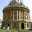

 84
[torch.LongStorage of size 1]



In [101]:
torch.save('mynet.dat', net)
eval = torch.load('mynet.dat') -- eval = net:clone()
eval:remove(#eval.modules)
eval:remove(#eval.modules)

-- Evaluate mode
eval:evaluate()
i = 93
print(classes[testset.label[i]])
itorch.image(testset.data[i])
local output = eval:forward(testset.data[i])
print(#output)

In [4]:
require 'paths';
require 'nn';
require 'image'

N = 0
names = {}
for line in io.lines() do
    N=N+1
    names[N] = line
end

data = torch.Tensor(torch.LongStorage({N,3,32,32}))
label = torch.Tensor(torch.LongStorage({N}))
for i=1,N do
    f = names[i]
    img = image.load('../../../team/oxbuild/classification/'..f,3,'byte')
    img = image.scale(img,'^32')
    img = image.crop(img,'c',32,32)
    data[i] = img
    class = f:sub(1,2)
    if (class == 'al') then
        label[i] = 1
    end
    if (class == 'as') then
        label[i] = 2
    end
    if (class == 'ch') then
        label[i] = 3
    end
    if (class == 'he') then
        label[i] = 4
    end
    if (class == 'ra') then
        label[i] = 5
    end
    names[i] = f
    i = i+1
end

-- print(#data)
-- print(#label)
-- -- print(label)

testset = {}
testset.data = data
testset.label = label
print(testset)

-- export = torch.load('oxbuild.dat','ascii')

-- net = export.net
-- mean = export.mean
-- stdv = export.stdv

-- classes = {'all_souls', 'ashmolean', 'christ_church', 'hertford',
--            'radcliffe_camera', 'distractor'}
           
-- testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
-- for i=1,3 do -- over each image channel
--     testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
--     testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
-- end

-- -- Evaluate mode
-- net:evaluate()

-- i = 1
-- output = net:forward(testset.data[i])
-- print(output:exp())
-- print(names[i])


{
  data : DoubleTensor - empty
  label : DoubleTensor - empty
}
